In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Importing the Libraries**

In [2]:
import os
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import OneHotEncoder


**Importing Dataset**

In [36]:
#fake1: Dalle
fake1="/content/drive/MyDrive/Deep Fake/Dataset/DM/Dalle/1_fake"
#fake2: Biggan
fake2="/content/drive/MyDrive/Deep Fake/Dataset/GAN/biggan"
#real: laion
real="/content/drive/MyDrive/Deep Fake/Dataset/Real/0_real"
train_fake=os.listdir(fake1)
test_fake=os.listdir(fake2)
real_fake=os.listdir(real)

In [4]:
print(len(train_fake))
print(len(test_fake))
print(len(real_fake))

1000
1200
1000


**Creating Training and Testing Dataset**

In [37]:
dataset=[]
test_dataset=[]
for i in range(800):
   train_fake[i]=fake1+'/'+train_fake[i]
   dataset.append([train_fake[i],1])

for i in range(200):
   test_fake[i]=fake2+'/'+test_fake[i]
   test_dataset.append([test_fake[i],1])

for i in range(800):
   real_fake[i]=real+'/'+real_fake[i]
   dataset.append([real_fake[i],0])

for i in range(800,1000):
   real_fake[i]=real+'/'+real_fake[i]
   test_dataset.append([real_fake[i],0])

Shuffling the dataset

In [6]:
random.shuffle(dataset)
random.shuffle(test_dataset)

In [7]:
print(dataset[0])

['/content/drive/MyDrive/Deep Fake/Dataset/DM/Dalle/1_fake/rdhrjwoyvx.png', 1]


In [8]:
X_train=[]
y_train=[]
for x in dataset:
    X_train.append(x[0])
    y_train.append(x[1])

**Split the Data into training and validation data**

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


Resizing the image according to model's input

In [10]:
def resize_image_3d(image_array, target_shape=(224, 224, 3)):
    if len(image_array.shape) != 3 or image_array.shape[2] != target_shape[2]:
        raise ValueError(f"Input array must have shape (height, width, {target_shape[2]})")

    resized_image = np.array(Image.fromarray(image_array).resize((target_shape[1], target_shape[0])))

    return resized_image


Opening the image and preprocessing

In [11]:
Im_train = []
Y_train = []

for i in range(len(X_train)):
    img = Image.open(X_train[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_train.append(im_array)
        Y_train.append(y_train[i])

Im_valid = []
Y_val = []

for i in range(len(X_val)):
    img = Image.open(X_val[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_valid.append(im_array)
        Y_val.append(y_val[i])


Defining the parameters

In [12]:
num_classes = 2
batch_size = 30
epochs = 10
learning_rate = 0.001



Loading the model:**Resnet50**

In [13]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 [==============================] - 0s 0us/step


Freezing the layers of Resnet50 Model

In [14]:
for layer in base_model.layers:
    layer.trainable = False

Adding the layers

In [15]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes, activation='softmax'))

Defining the hyperparameters

In [16]:
sgd_optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
Im_train = np.array(Im_train)
Y_train = np.array(Y_train)
Im_valid = np.array(Im_valid)
Y_val = np.array(Y_val)

Encoding the output into one hot encoding

In [18]:
encoder = OneHotEncoder(sparse=False)
Y_train_encoded = encoder.fit_transform(Y_train.reshape(-1, 1))
Y_val_encoded = encoder.transform(Y_val.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**Training the Model**

In [19]:
history = model.fit(
    Im_train, Y_train_encoded,
    epochs=epochs,
    validation_data=(Im_valid, Y_val_encoded)
)

Epoch 1/10
45/45 [==============================] - 305s 7s/step - loss: 0.5530 - accuracy: 0.7495 - val_loss: 0.3988 - val_accuracy: 0.8687
Epoch 2/10
45/45 [==============================] - 312s 7s/step - loss: 0.2980 - accuracy: 0.8730 - val_loss: 0.3614 - val_accuracy: 0.8750
Epoch 3/10
45/45 [==============================] - 305s 7s/step - loss: 0.2421 - accuracy: 0.9016 - val_loss: 0.3328 - val_accuracy: 0.8687
Epoch 4/10
45/45 [==============================] - 298s 7s/step - loss: 0.2209 - accuracy: 0.9135 - val_loss: 0.3448 - val_accuracy: 0.8813
Epoch 5/10
45/45 [==============================] - 316s 7s/step - loss: 0.2154 - accuracy: 0.9128 - val_loss: 0.3317 - val_accuracy: 0.8750
Epoch 6/10
45/45 [==============================] - 314s 7s/step - loss: 0.1746 - accuracy: 0.9309 - val_loss: 0.3217 - val_accuracy: 0.8813
Epoch 7/10
45/45 [==============================] - 317s 7s/step - loss: 0.1608 - accuracy: 0.9477 - val_loss: 0.3081 - val_accuracy: 0.8875
Epoch 8/10
45

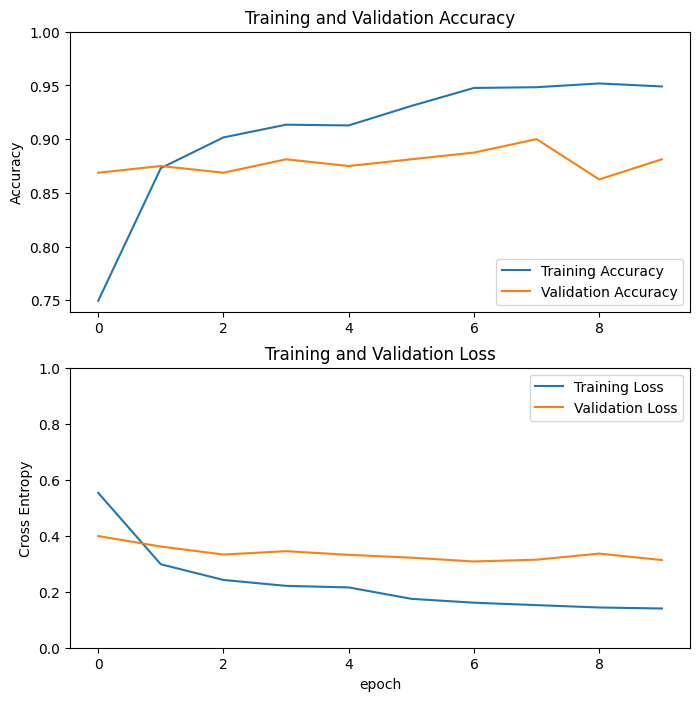

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning the Model**

Unfreezing the last 10 layers for fine tuning

In [21]:
for layer in base_model.layers[40:]:
    layer.trainable = True

Defining parameters for Fine Tuning

In [22]:
sgd_optimizer = optimizers.SGD(learning_rate=learning_rate/10, momentum=0.9)
model.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Again training the model

In [23]:
history_fine = model.fit(
    Im_train, Y_train_encoded,
    epochs=15,
    initial_epoch=history.epoch[-1],
    validation_data=(Im_valid, Y_val_encoded)
)

Epoch 10/15
45/45 [==============================] - 871s 19s/step - loss: 0.4570 - accuracy: 0.8109 - val_loss: 0.6710 - val_accuracy: 0.7063
Epoch 11/15
45/45 [==============================] - 836s 19s/step - loss: 0.1945 - accuracy: 0.9358 - val_loss: 0.3921 - val_accuracy: 0.8250
Epoch 12/15
45/45 [==============================] - 821s 18s/step - loss: 0.1620 - accuracy: 0.9546 - val_loss: 0.3021 - val_accuracy: 0.8750
Epoch 13/15
45/45 [==============================] - 834s 19s/step - loss: 0.1414 - accuracy: 0.9595 - val_loss: 0.2660 - val_accuracy: 0.9000
Epoch 14/15
45/45 [==============================] - 837s 19s/step - loss: 0.1178 - accuracy: 0.9700 - val_loss: 0.2383 - val_accuracy: 0.9187
Epoch 15/15
45/45 [==============================] - 819s 18s/step - loss: 0.1044 - accuracy: 0.9749 - val_loss: 0.2187 - val_accuracy: 0.9250


In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

**Saving the Model**

In [26]:
model.save('/content/drive/MyDrive/Deep Fake/fine_tuned_level1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Creating Test Dataset

In [38]:
X_test=[]
y_test=[]
for x in test_dataset:
    X_test.append(x[0])
    y_test.append(x[1])

In [39]:
Im_test = []
Y_test = []

for i in range(len(X_test)):
    img = Image.open(X_test[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_test.append(im_array)
        Y_test.append(y_test[i])

In [40]:
Im_test = np.array(Im_test)
Y_test = np.array(Y_test)

Encoding the output

In [41]:
Y_test_encoded = encoder.transform(Y_test.reshape(-1, 1))

Evaluating the MOdel

In [42]:
evaluation = model.evaluate(Im_test, Y_test_encoded)

13/13 [==============================] - 75s 6s/step - loss: 0.4313 - accuracy: 0.7696


In [43]:
print(evaluation)

[0.4313402771949768, 0.7696202397346497]


In [44]:
accuracy = evaluation[1]

print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.7696202397346497
